## Portafolio de 10 Empresas

En esta sección construiremos un portafolio configurable de 10 emisoras. Podrás cambiar la lista fácilmente en la primera celda de código. Para cada activo:

- Descargamos precios (close)
- Calculamos la estrategia SMA (rápida vs lenta) por defecto (21/63)
- Obtenemos métricas: Total Return, CAGR, Volatilidad anualizada, Sharpe, Max Drawdown, Calmar, Nº Trades, Win Rate, % Tiempo en Posición Larga, % Tiempo en Posición Corta
- Comparamos Buy & Hold vs Estrategia
- Construimos un portafolio equiponderado (Buy & Hold y Estrategia).

Puedes reemplazar los tickers en la lista `TICKERS` y re‑ejecutar desde ahí.

In [1]:
# Configuración inicial del portafolio
# Puedes cambiar libremente estos tickers (máximo o mínimo los que quieras)

TICKERS = [
    'JPM','RY.TO','8058.T','BA','LMT',
    'NVDA','MSFT.O','SAND.K','VLO','SIEGn.DE'
]

# Parámetros de la estrategia de medias móviles
FAST_WINDOW = 21
SLOW_WINDOW = 63

# Capital inicial para métricas (no se usa en cálculo de retorno porcentual acumulado, solo para equity hipotético)
INITIAL_CAPITAL = 1_000_000

# Reemplazar TICKERS por los símbolos definidos en symbols_map
# TICKERS = list(symbols_map.values())
TICKERS

['JPM',
 'RY.TO',
 '8058.T',
 'BA',
 'LMT',
 'NVDA',
 'MSFT.O',
 'SAND.K',
 'VLO',
 'SIEGn.DE']

In [2]:
# --- Setup centralizado: imports, parámetros y utilidades ---
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from datetime import date, timedelta
from datafromsource import DataFromSource

# Fechas y benchmark globales
TODAY = date.today()
END_OF_YEAR = date(TODAY.year, 12, 31)
BENCH_TICKER = '^GSPC'  # proxy S&P500; cambiar si tu fuente usa otro RIC

# Output folder
OUT_DIR = 'outputs'
os.makedirs(OUT_DIR, exist_ok=True)

# Display options
pd.options.display.float_format = '{:,.4f}'.format

# Nota: las variables FAST_WINDOW, SLOW_WINDOW e INITIAL_CAPITAL las definimos en la celda de parámetros superior


In [3]:
@dataclass
class StrategyMetrics:
    ticker: str
    start: pd.Timestamp
    end: pd.Timestamp
    n_days: int
    total_return_bh: float
    total_return_strat: float
    cagr_bh: float
    cagr_strat: float
    vol_bh: float
    vol_strat: float
    sharpe_bh: float
    sharpe_strat: float
    max_dd_bh: float
    max_dd_strat: float
    calmar_bh: float
    calmar_strat: float
    trades: int
    win_rate: float
    pct_long: float
    pct_short: float

def max_drawdown(cum_returns: pd.Series) -> float:
    roll_max = cum_returns.cummax()
    dd = (cum_returns / roll_max) - 1.0
    return dd.min()

def cagr(total_return: float, n_days: int) -> float:
    years = n_days / 252
    if years <= 0:
        return np.nan
    return (1 + total_return) ** (1 / years) - 1

def annualized_vol(daily_returns: pd.Series) -> float:
    return daily_returns.std() * np.sqrt(252)

def sharpe_ratio(daily_returns: pd.Series, rf: float = 0.0) -> float:
    # rf asumido 0 para simplicidad
    vol = annualized_vol(daily_returns)
    if vol == 0 or np.isnan(vol):
        return np.nan
    return (daily_returns.mean() * 252 - rf) / vol

def build_sma_strategy(df: pd.DataFrame, fast: int, slow: int) -> pd.DataFrame:
    data = df.copy()
    data[f'SMA_{fast}'] = data['close'].rolling(fast).mean()
    data[f'SMA_{slow}'] = data['close'].rolling(slow).mean()
    data['position'] = np.where(data[f'SMA_{fast}'] > data[f'SMA_{slow}'], 1, -1)
    data['ret'] = np.log(data['close'] / data['close'].shift(1))
    data['strat_ret'] = data['position'].shift(1) * data['ret']
    data.dropna(inplace=True)
    return data

def count_trades(position_series: pd.Series) -> int:
    # Conteo de cambios de signo (ignora NaN inicial)
    pos = position_series.dropna()
    changes = (pos != pos.shift(1))
    return int(changes.sum())

def build_metrics(ticker: str, data: pd.DataFrame) -> StrategyMetrics:
    cum_bh = data['ret'].cumsum().apply(np.exp)
    cum_strat = data['strat_ret'].cumsum().apply(np.exp)
    total_return_bh = cum_bh.iloc[-1] - 1
    total_return_strat = cum_strat.iloc[-1] - 1
    n_days = data.shape[0]

    cagr_b = cagr(total_return_bh, n_days)
    cagr_s = cagr(total_return_strat, n_days)
    vol_b = annualized_vol(data['ret'])
    vol_s = annualized_vol(data['strat_ret'])
    sharpe_b = sharpe_ratio(data['ret'])
    sharpe_s = sharpe_ratio(data['strat_ret'])
    max_dd_b = max_drawdown(cum_bh)
    max_dd_s = max_drawdown(cum_strat)
    calmar_b = np.nan if max_dd_b == 0 else cagr_b / abs(max_dd_b)
    calmar_s = np.nan if max_dd_s == 0 else cagr_s / abs(max_dd_s)
    trades = count_trades(data['position'])

    # Win rate: porcentaje de días con retorno de estrategia > 0
    win_rate = (data['strat_ret'] > 0).mean()
    pct_long = (data['position'] == 1).mean()
    pct_short = (data['position'] == -1).mean()

    return StrategyMetrics(
        ticker=ticker,
        start=data.index[0],
        end=data.index[-1],
        n_days=n_days,
        total_return_bh=total_return_bh,
        total_return_strat=total_return_strat,
        cagr_bh=cagr_b,
        cagr_strat=cagr_s,
        vol_bh=vol_b,
        vol_strat=vol_s,
        sharpe_bh=sharpe_b,
        sharpe_strat=sharpe_s,
        max_dd_bh=max_dd_b,
        max_dd_strat=max_dd_s,
        calmar_bh=calmar_b,
        calmar_strat=calmar_s,
        trades=trades,
        win_rate=win_rate,
        pct_long=pct_long,
        pct_short=pct_short
    )

def metrics_to_frame(metrics_list):
    rows = []
    for m in metrics_list:
        rows.append({
            'Ticker': m.ticker,
            'Start': m.start.date(),
            'End': m.end.date(),
            'Días': m.n_days,
            'TotRet_BH': m.total_return_bh,
            'TotRet_Strat': m.total_return_strat,
            'CAGR_BH': m.cagr_bh,
            'CAGR_Strat': m.cagr_strat,
            'Vol_BH': m.vol_bh,
            'Vol_Strat': m.vol_strat,
            'Sharpe_BH': m.sharpe_bh,
            'Sharpe_Strat': m.sharpe_strat,
            'MaxDD_BH': m.max_dd_bh,
            'MaxDD_Strat': m.max_dd_strat,
            'Calmar_BH': m.calmar_bh,
            'Calmar_Strat': m.calmar_strat,
            'Trades': m.trades,
            'WinRate': m.win_rate,
            'Pct_Long': m.pct_long,
            'Pct_Short': m.pct_short
        })
    dfm = pd.DataFrame(rows)
    cols_pct = ['TotRet_BH','TotRet_Strat','CAGR_BH','CAGR_Strat','MaxDD_BH','MaxDD_Strat']
    # Formato rápido (se puede estilizar después)
    return dfm

In [4]:
from datafromsource import DataFromSource

all_data = {}
metrics_list = []

for tk in TICKERS:
    src = DataFromSource(tk)
    raw = src.get_prices()
    strat_df = build_sma_strategy(raw, FAST_WINDOW, SLOW_WINDOW)
    m = build_metrics(tk, strat_df)
    metrics_list.append(m)
    all_data[tk] = strat_df

metrics_df = metrics_to_frame(metrics_list)
metrics_df = metrics_df.sort_values('CAGR_Strat', ascending=False).reset_index(drop=True)

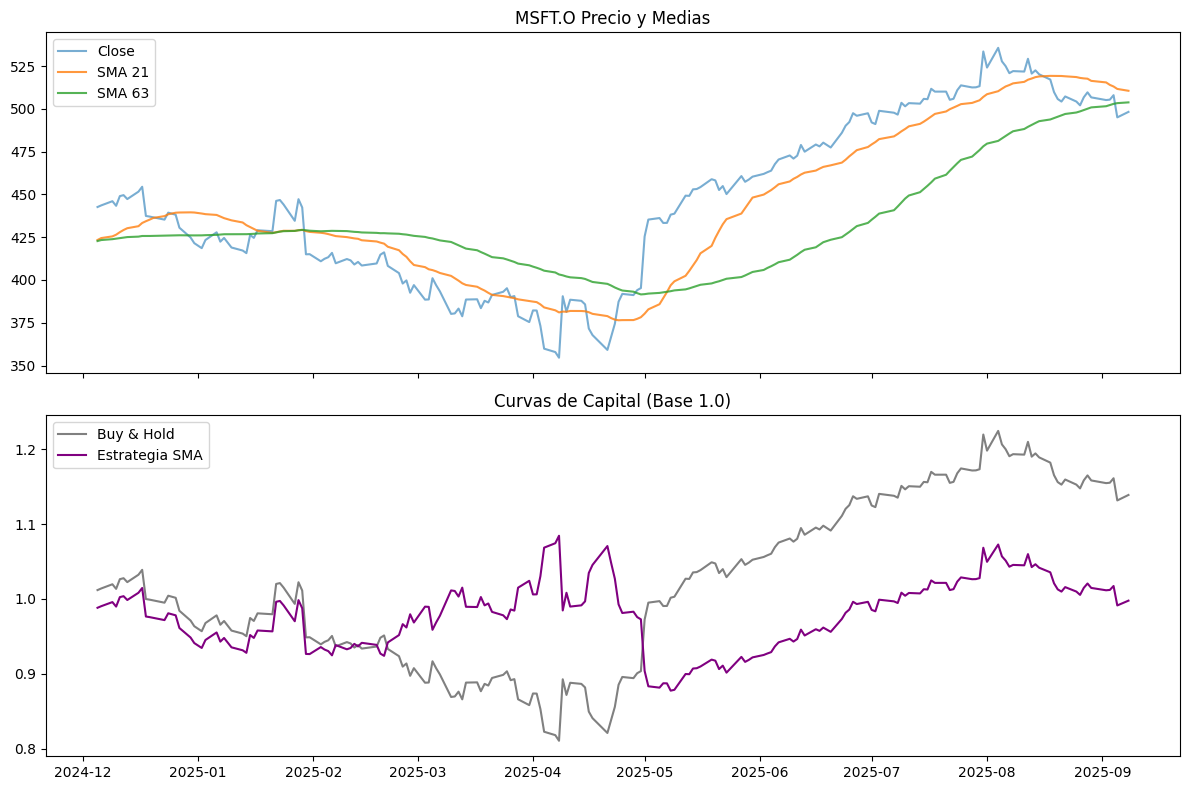

,Ticker,Start,End,Días,TotRet_BH,TotRet_Strat,CAGR_BH,CAGR_Strat,Vol_BH,Vol_Strat,Sharpe_BH,Sharpe_Strat,MaxDD_BH,MaxDD_Strat,Calmar_BH,Calmar_Strat,Trades,WinRate,Pct_Long,Pct_Short
4,MSFT.O,2024-12-05,2025-09-08,188,0.1390,-0.0022,0.1905,-0.0030,0.2581,0.2584,0.6756,-0.0116,-0.2198,-0.1908,0.8668,-0.0157,3,0.5000,0.6383,0.3617


In [5]:
# Visualización para un ticker específico
TICKER_VIEW = 'MSFT.O'  # cambia este valor para ver otro

dv = all_data[TICKER_VIEW]
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
axes[0].plot(dv.index, dv['close'], label='Close', alpha=0.6)
axes[0].plot(dv.index, dv[f'SMA_{FAST_WINDOW}'], label=f'SMA {FAST_WINDOW}', alpha=0.8)
axes[0].plot(dv.index, dv[f'SMA_{SLOW_WINDOW}'], label=f'SMA {SLOW_WINDOW}', alpha=0.8)
axes[0].set_title(f'{TICKER_VIEW} Precio y Medias')
axes[0].legend(loc='upper left')

cum_bh = dv['ret'].cumsum().apply(np.exp)
cum_str = dv['strat_ret'].cumsum().apply(np.exp)
axes[1].plot(cum_bh.index, cum_bh, label='Buy & Hold', color='gray')
axes[1].plot(cum_str.index, cum_str, label='Estrategia SMA', color='purple')
axes[1].set_title('Curvas de Capital (Base 1.0)')
axes[1].legend(loc='upper left')
plt.tight_layout()
plt.show()

metrics_df[metrics_df['Ticker'] == TICKER_VIEW]

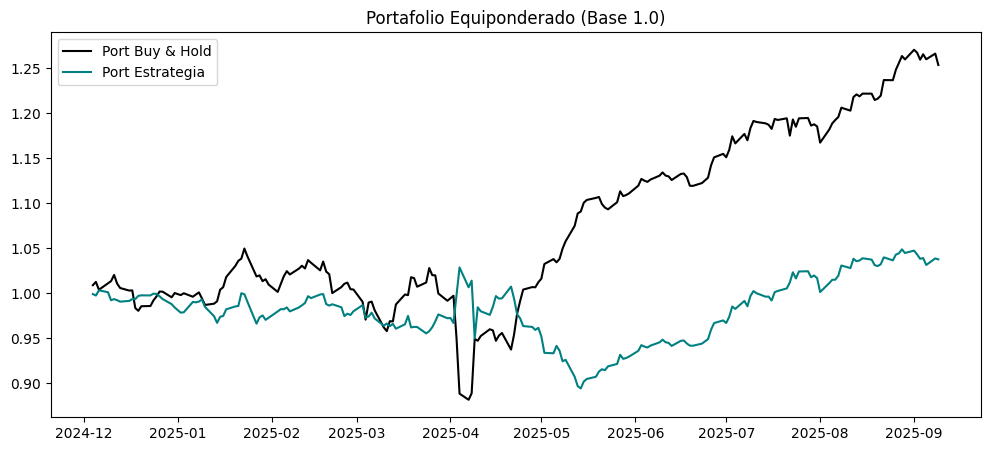

{'TotRet_BH': np.float64(0.25357542821699663),
 'TotRet_Strat': np.float64(0.0376393556705541),
 'CAGR_BH': np.float64(0.3313463391587532),
 'CAGR_Strat': np.float64(0.047900648396132395),
 'Vol_BH': np.float64(0.17661662702529493),
 'Vol_Strat': np.float64(0.1433124679019924),
 'Sharpe_BH': np.float64(1.6204064142806203),
 'Sharpe_Strat': np.float64(0.3264808773525997),
 'MaxDD_BH': np.float64(-0.16008439054400037),
 'MaxDD_Strat': np.float64(-0.13068289254546228)}

In [6]:
# Portafolio equiponderado
# Alineamos retornos diarios de cada activo
rets_bh = []
rets_str = []
for tk, dfv in all_data.items():
    rets_bh.append(dfv['ret'].rename(tk))
    rets_str.append(dfv['strat_ret'].rename(tk))

rets_bh = pd.concat(rets_bh, axis=1).dropna(how='all')
rets_str = pd.concat(rets_str, axis=1).reindex(index=rets_bh.index).fillna(0)

# Promedio simple (equiponderado)
port_ret_bh = rets_bh.mean(axis=1)
port_ret_str = rets_str.mean(axis=1)

cum_bh_port = port_ret_bh.cumsum().apply(np.exp)
cum_str_port = port_ret_str.cumsum().apply(np.exp)

fig, ax = plt.subplots(figsize=(12,5))
ax.plot(cum_bh_port, label='Port Buy & Hold', color='black')
ax.plot(cum_str_port, label='Port Estrategia', color='teal')
ax.set_title('Portafolio Equiponderado (Base 1.0)')
ax.legend()
plt.show()

# Métricas agregadas del portafolio
port_metrics = {
    'TotRet_BH': cum_bh_port.iloc[-1]-1,
    'TotRet_Strat': cum_str_port.iloc[-1]-1,
    'CAGR_BH': cagr(cum_bh_port.iloc[-1]-1, len(cum_bh_port)),
    'CAGR_Strat': cagr(cum_str_port.iloc[-1]-1, len(cum_str_port)),
    'Vol_BH': annualized_vol(port_ret_bh),
    'Vol_Strat': annualized_vol(port_ret_str),
    'Sharpe_BH': sharpe_ratio(port_ret_bh),
    'Sharpe_Strat': sharpe_ratio(port_ret_str),
    'MaxDD_BH': max_drawdown(cum_bh_port),
    'MaxDD_Strat': max_drawdown(cum_str_port),
}
port_metrics

### Notas y Personalización

- Para cambiar emisoras, edita la lista `TICKERS` y re‑ejecuta desde esa celda.
- Puedes ajustar ventanas `FAST_WINDOW` y `SLOW_WINDOW`.
- Agrega otras reglas (RSI, MAMA, etc.) creando nuevas funciones similares a `build_sma_strategy`.
- Para ponderaciones distintas (por ejemplo basadas en volatilidad inversa), reemplaza el promedio simple por un vector de pesos.
- Para incluir costos de transacción: multiplica `strat_ret` por `(1 - cost)` en días de cambio de posición.

Siguientes ideas:
1. Optimización de ventanas via grid search.
2. Filtrar trades con volatilidad anormal.
3. Incorporar stop-loss y take-profit.
4. Evaluar correlaciones y diversificación efectiva (N efectivo = 1 / sum w_i^2).
5. Exportar resultados a CSV: `metrics_df.to_csv('metrics_individuales.csv', index=False)`.

Listo para tus modificaciones.

### Señales vs Predicción

Las reglas que implementamos (cruce de medias, MAMA, etc.) NO "predicen" el futuro; generan **señales reactivas** basadas en precios ya observados. Una señal de compra aparece cuando la media rápida supera a la lenta (cambio de tendencia reciente), no porque sepamos que subirá después. 

Para intentar predecir (en sentido estadístico) necesitarías modelos de pronóstico (ARIMA, Prophet, LSTM, factores macro, etc.) y siempre habrá incertidumbre. Las reglas técnicas:
- Filtran ruido para entrar cuando hay momentum / tendencia.
- Reducen subjetividad.
- Pueden fallar en mercados laterales (whipsaw).

Por eso medimos desempeño histórico (backtest) para ver **cómo habría funcionado**, no para garantizar resultados futuros.

A continuación integramos la parte esencial de Markowitz para optimizar pesos del portafolio usando los retornos diarios (Buy & Hold o Estrategia).

In [7]:
# --- Preparación datos para Markowitz ---
# Usa retornos de la estrategia o Buy & Hold. Cambia USE_STRATEGY = True/False
USE_STRATEGY = True

rets_for_mkv = []
for tk, d in all_data.items():
    col = 'strat_ret' if USE_STRATEGY else 'ret'
    rets_for_mkv.append(d[col].rename(tk))

returns_mkv = pd.concat(rets_for_mkv, axis=1).dropna()
returns_mkv.head()

,JPM,RY.TO,8058.T,BA,LMT,NVDA,MSFT.O,SAND.K,VLO,SIEGn.DE
Date,,,,,,,,,,
2025-01-08,-0.0002,0.0042,0.0139,-0.0044,-0.0105,0.0079,0.0052,-0.0088,-0.0096,0.0108
2025-01-10,-0.0135,-0.0206,0.0018,0.0014,0.0017,-0.0217,-0.0133,0.0071,-0.0155,-0.0107
2025-01-14,0.0133,-0.0025,-0.0118,-0.0210,-0.0027,-0.0142,-0.0037,-0.0320,-0.0053,0.0040
2025-01-15,0.0195,0.0070,0.0048,-0.0049,0.0010,0.0435,0.0253,-0.0070,-0.0283,0.0083
2025-01-17,0.0190,-0.0082,0.0140,0.0127,-0.0071,0.0225,0.0104,-0.0053,-0.0120,0.0287


### Objetivo: Superar el S&P500 entre hoy y fin de año

A continuación añadimos una sección que: (1) descarga datos del benchmark (S&P500 proxy), (2) calcula ROIC aproximado cuando es posible, y (3) propone una regla simple para sobrepesar activos con ROIC alto para el horizonte corto Sept-Dic y compara contra el benchmark.

In [8]:
# Parámetros objetivo y fechas
from datetime import date, timedelta
TODAY = date.today()
END_OF_YEAR = date(TODAY.year, 12, 31)
BENCH_TICKER = '^GSPC'  # proxy S&P500; cambiar si tu fuente usa otro RIC
HOLDING_DAYS = (END_OF_YEAR - TODAY).days
HOLDING_DAYS

113

In [9]:
# Función defensiva para obtener fundamentales y calcular ROIC aproximado
from datafromsource import DataFromSource
import numpy as np
def fetch_fundamentals_roic(ticker, session=None):
    # Intenta descargar campos comunes; devuelve dict con campos y roic (o np.nan)
    src = DataFromSource(ticker)
    # intentaremos varios nombres posibles para EBIT / NOPAT y capital empleado
    candidates = {
        'ebit': ['TR.EBIT','EBIT','tr.EBIT','TR.EBITDA - TR.DEPREC', 'TR.OperatingIncome'],
        'tax_rate': ['TR.EffectiveTaxRate','TaxRate','tr.TaxRate'],
        'total_assets': ['TR.TotalAssets','Total Assets','tr.TotalAssets'],
        'current_liab': ['TR.TotalCurrentLiabilities','Current Liabilities','tr.CurrentLiabilities'],
        'total_debt': ['TR.TotalDebt','Total Debt','tr.TotalDebt'],
    }
    out = {'ticker': ticker}
    try:
        ld = src.get_session()
        # Pedimos datos anuales (1Y) para los campos que existan; la API puede ignorar campos desconocidos
        fields = []
        for v in candidates.values():
            fields += v
        fields = list(dict.fromkeys(fields))
        today = date.today()
        start = today - timedelta(days=5*365)
        try:
            fdata = ld.get_history(universe=[ticker], fields=fields, interval='1Y', start=start, end=today)
        except Exception as e:
            # intentar sin interval
            try:
                fdata = ld.get_history(universe=[ticker], fields=fields)
            except Exception as e2:
                return out
        # normalizar columnas: buscar valores numéricos en las columnas devueltas
        flat = {}
        for c in fdata.columns:
            flat[c.lower().strip()] = fdata[c].iloc[-1] if hasattr(fdata[c], 'iloc') else fdata[c]
        # intentar mapear candidatos
        def pick(keys):
            for k in keys:
                k2 = k.lower().replace('.', '').replace(' ', '')
                for col in flat:
                    if k2 in col.replace(' ', '').replace('.', ''):
                        try:
                            return float(flat[col])
                        except Exception:
                            pass
            return np.nan
        ebit = pick(candidates['ebit'])
        tax = pick(candidates['tax_rate'])
        ta = pick(candidates['total_assets'])
        cl = pick(candidates['current_liab'])
        td = pick(candidates['total_debt'])
        out.update({'ebit':ebit,'tax_rate':tax,'total_assets':ta,'current_liab':cl,'total_debt':td})
        # Calcular NOPAT y capital empleado si hay datos
        if not np.isnan(ebit):
            tr = tax if (not np.isnan(tax) and tax>0 and tax<1) else 0.21
            nopat = ebit * (1 - tr)
        else:
            nopat = np.nan
        cap_employed = np.nan
        if (not np.isnan(ta)) and (not np.isnan(cl)):
            cap_employed = ta - cl
        elif (not np.isnan(td)) and (not np.isnan(ta)):
            # approximation: equity = total_assets - total_debt -> capital employed ~= equity + net debt = total_assets
            cap_employed = ta
        roic = nopat / cap_employed if (not np.isnan(nopat) and not np.isnan(cap_employed) and cap_employed!=0) else np.nan
        out.update({'nopat':nopat,'cap_employed':cap_employed,'roic':roic})
        return out
    except Exception as e:
        return out

In [10]:
# Obtener ROIC para cada ticker (puede tardar si la API es lenta). Guardamos resultados en un DataFrame.
fund_rows = []
for tk in TICKERS:
    info = fetch_fundamentals_roic(tk)
    fund_rows.append(info)
fund_df = pd.DataFrame(fund_rows).set_index('ticker')
fund_df

c:\Users\Juan Marco\AppData\Local\Programs\Python\Python311\Lib\site-packages\lseg\data\_access_layer\_containers.py:126:UserWarning: You have duplicated fields in your input. Output will contain unique fields only.


c:\Users\Juan Marco\AppData\Local\Programs\Python\Python311\Lib\site-packages\lseg\data\_tools\_dataframe.py:192:FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
c:\Users\Juan Marco\AppData\Local\Programs\Python\Python311\Lib\site-packages\lseg\data\_access_layer\_containers.py:126:UserWarning: You have duplicated fields in your input. Output will contain unique fields only.


,ebit,tax_rate,total_assets,current_liab,total_debt,nopat,cap_employed,roic
ticker,,,,,,,,
JPM,"95,054,000,000.0000",19.5741,"3,875,393,000,000.0000",NaN,"611,826,000,000.0000","75,092,660,000.0000","3,875,393,000,000.0000",0.0194
RY.TO,"49,604,000,000.0000",18.2358,"2,171,582,000,000.0000",NaN,"358,826,000,000.0000","39,187,160,000.0000","2,171,582,000,000.0000",0.0180
8058.T,"571,085,000,000.0000",24.7862,"23,459,572,000,000.0000","8,132,081,000,000.0000","5,686,591,000,000.0000","451,157,150,000.0000","15,327,491,000,000.0000",0.0294
BA,"752,000,000.0000",NaN,"137,012,000,000.0000","95,827,000,000.0000","52,307,000,000.0000","594,080,000.0000","41,185,000,000.0000",0.0144
LMT,"8,559,000,000.0000",14.5468,"52,456,000,000.0000","16,937,000,000.0000","17,459,000,000.0000","6,761,610,000.0000","35,519,000,000.0000",0.1904
NVDA,"33,595,000,000.0000",11.9995,"65,727,999,999.9999","10,631,000,000.0000","9,709,000,000.0000","26,540,050,000.0000","55,096,999,999.9999",0.4817
MSFT.O,"109,433,000,000.0000",18.2313,"512,163,000,000.0000","125,286,000,000.0000","78,775,000,000.0000","86,452,070,000.0000","386,877,000,000.0000",0.2235
SAND.K,"60,765,000.0000",8.9593,"1,931,426,000.0000","16,193,000.0000","452,200,000.0000","48,004,350.0000","1,915,233,000.0000",0.0251
VLO,"11,858,000,000.0000",22.2553,"63,056,000,000.0000","16,802,000,000.0000","11,524,000,000.0000","9,367,820,000.0000","46,254,000,000.0000",0.2025


### Estrategia simple para el horizonte Sept-Dic

Regla propuesta: sobrepesar (2x) activos con ROIC por encima del percentil 66 y Sharpe histórico positivo; normalizar pesos para sumar 1. Comparar la curva de capital resultante con el S&P500 en el mismo periodo.
Nota: esto es heurístico y no garantiza outperformance; es un experimento de corto plazo.

In [11]:
# Construir vector de puntaje simple: roic z sharpe
score = pd.Series(index=TICKERS, dtype=float)
for tk in TICKERS:
    r = fund_df.loc[tk,'roic'] if ('roic' in fund_df.columns and tk in fund_df.index) else np.nan
    s = metrics_df.loc[metrics_df['Ticker']==tk,'Sharpe_Strat'].values[0] if (tk in metrics_df['Ticker'].values) else np.nan
    score.loc[tk] = (0 if np.isnan(r) else r) + (0 if np.isnan(s) else s)
# percentil 66
cut = score.dropna().quantile(0.66) if not score.dropna().empty else np.nan
weights = pd.Series(1/len(TICKERS), index=TICKERS, dtype=float)
if not np.isnan(cut):
    high = score[score >= cut].index.tolist()
    # sobrepeso 2x a estos activos y renormalizar
    weights = pd.Series(1.0, index=TICKERS, dtype=float)
    weights.loc[high] = 2.0
    weights = weights / weights.sum()
weights

JPM        0.0714
RY.TO      0.0714
8058.T     0.1429
BA         0.0714
LMT        0.1429
NVDA       0.1429
MSFT.O     0.0714
SAND.K     0.1429
VLO        0.0714
SIEGn.DE   0.0714
dtype: float64

In [12]:
# Evaluar rendimiento entre hoy y fin de año: construir series de retornos para el periodo y comparar con benchmark
# Alineamos índices y tomamos subperiodo
# concatenar retornos diarios de cada activo (strat_ret) en returns_mkv si no existe ya
try:
    period_index = pd.date_range(start=pd.Timestamp(TODAY), end=pd.Timestamp(END_OF_YEAR), freq='B')
    # obtener retornos diarios por activo desde all_data (strat_ret)
    rets_short = []
    for tk, dfv in all_data.items():
        s = dfv['strat_ret'].reindex(period_index).fillna(0).rename(tk)
        rets_short.append(s)
    rets_short = pd.concat(rets_short, axis=1)
    # portafolio con pesos definidos
    port_short = (rets_short * weights).sum(axis=1).cumsum().apply(np.exp)
    # benchmark: intentar descargar precios del BENCH_TICKER usando DataFromSource
    bench = DataFromSource(BENCH_TICKER).get_prices()
    bench_ret = np.log(bench['close'] / bench['close'].shift(1)).reindex(period_index).fillna(0)
    bench_cum = bench_ret.cumsum().apply(np.exp)
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10,5))
    plt.plot(port_short.index, port_short, label='Port Sep-Dec (estrategia)')
    plt.plot(bench_cum.index, bench_cum, label='S&P500 proxy')
    plt.legend()
    plt.title('Comparación portafolio vs S&P500 (Sep-Dic)')
    plt.show()
    # métricas simples
    final = {'Port_Return': port_short.iloc[-1]-1, 'Bench_Return': bench_cum.iloc[-1]-1}
    final
except Exception as e:
    print('Error al evaluar periodo corto:', e)
    {}

Error retrieving data for ^GSPC: Unable to resolve all requested identifiers in ['^GSPC'].
Error al evaluar periodo corto: 'NoneType' object is not subscriptable


In [13]:
import numpy as np
from scipy.optimize import minimize

periods_per_year = 252
mean_daily = returns_mkv.mean()
cov_daily = returns_mkv.cov()
mean_annual = mean_daily * periods_per_year
cov_annual = cov_daily * periods_per_year
rf = 0.0  # Ajusta si tienes tasa libre de riesgo
n_assets = returns_mkv.shape[1]

# Funciones

def portfolio_perf(weights, mean_ret=mean_annual, cov=cov_annual, rf=rf):
    ret = np.dot(weights, mean_ret)
    vol = np.sqrt(weights @ cov @ weights)
    sharpe = (ret - rf) / vol if vol > 0 else np.nan
    return ret, vol, sharpe

def max_sharpe(short=False):
    bounds = ((-1,1) if short else (0,1),) * n_assets
    x0 = np.full(n_assets, 1/n_assets)
    cons = ({'type':'eq','fun':lambda w: np.sum(w)-1})
    def neg_sharpe(w):
        return -portfolio_perf(w)[2]
    res = minimize(neg_sharpe, x0, method='SLSQP', bounds=bounds, constraints=cons)
    return res

def min_vol(short=False):
    bounds = ((-1,1) if short else (0,1),) * n_assets
    x0 = np.full(n_assets, 1/n_assets)
    cons = ({'type':'eq','fun':lambda w: np.sum(w)-1})
    def vol(w):
        return portfolio_perf(w)[1]
    res = minimize(vol, x0, method='SLSQP', bounds=bounds, constraints=cons)
    return res

def efficient_frontier(target_returns, short=False):
    bounds = ((-1,1) if short else (0,1),) * n_assets
    x0 = np.full(n_assets, 1/n_assets)
    cons_base = ({'type':'eq','fun':lambda w: np.sum(w)-1},)
    ef_points = []
    for tr in target_returns:
        cons = cons_base + ({'type':'eq','fun':lambda w, tr=tr: np.dot(w, mean_annual)-tr},)
        res = minimize(lambda w: np.sqrt(w @ cov_annual @ w), x0, method='SLSQP', bounds=bounds, constraints=cons)
        if res.success:
            r,v,_ = portfolio_perf(res.x)
            ef_points.append((r,v,res.x))
    return ef_points

# Ejecutar optimizaciones
res_ms = max_sharpe(short=False)
res_mv = min_vol(short=False)

ret_ms, vol_ms, sr_ms = portfolio_perf(res_ms.x)
ret_mv, vol_mv, sr_mv = portfolio_perf(res_mv.x)

print('Max Sharpe -> Ret: {:.2%} Vol: {:.2%} Sharpe: {:.2f}'.format(ret_ms, vol_ms, sr_ms))
print('Min Vol    -> Ret: {:.2%} Vol: {:.2%} Sharpe: {:.2f}'.format(ret_mv, vol_mv, sr_mv))

Max Sharpe -> Ret: 34.72% Vol: 20.13% Sharpe: 1.72
Min Vol    -> Ret: -3.43% Vol: 11.17% Sharpe: -0.31


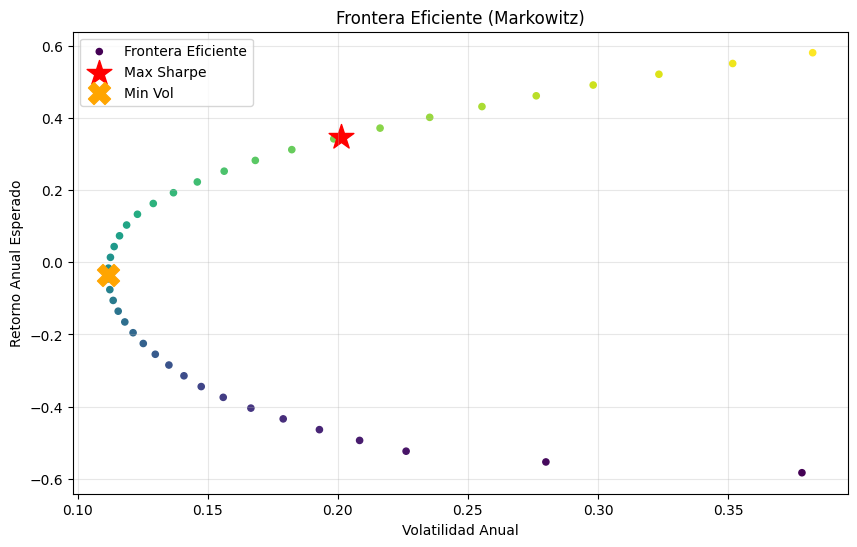

,Peso_MaxSharpe,Peso_MinVol
Activo,,
JPM,0.0000,0.0588
RY.TO,0.0000,0.3458
8058.T,0.2735,0.1376
BA,0.0000,0.0000
LMT,0.0000,0.0952
NVDA,0.0000,0.0000
MSFT.O,0.2166,0.1094
SAND.K,0.5099,0.1563
VLO,0.0000,0.0284


In [14]:
# Frontera eficiente
tr_min, tr_max = mean_annual.min(), mean_annual.max()
target_grid = np.linspace(tr_min, tr_max, 40)
frontier = efficient_frontier(target_grid, short=False)

# Preparar datos
fr_ret = [p[0] for p in frontier]
fr_vol = [p[1] for p in frontier]

plt.figure(figsize=(10,6))
plt.scatter(fr_vol, fr_ret, s=20, c=fr_ret, cmap='viridis', label='Frontera Eficiente')
plt.scatter(vol_ms, ret_ms, marker='*', s=350, c='red', label='Max Sharpe')
plt.scatter(vol_mv, ret_mv, marker='X', s=250, c='orange', label='Min Vol')
plt.xlabel('Volatilidad Anual')
plt.ylabel('Retorno Anual Esperado')
plt.title('Frontera Eficiente (Markowitz)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Pesos
weights_df = pd.DataFrame({
    'Activo': returns_mkv.columns,
    'Peso_MaxSharpe': res_ms.x,
    'Peso_MinVol': res_mv.x
}).set_index('Activo')
weights_df

## Matriz de correlación entre activos

Calculamos la matriz de correlación entre los retornos que usamos para Markowitz y mostramos un heatmap.

Correlación (primeras filas):


,JPM,RY.TO,8058.T,BA,LMT,NVDA,MSFT.O,SAND.K,VLO,SIEGn.DE
JPM,1.0000,0.2241,-0.0162,0.6122,0.2127,0.3423,0.4339,-0.1908,0.3985,0.1831
RY.TO,0.2241,1.0000,-0.0442,0.2699,0.1168,0.2119,0.4658,-0.2479,0.1646,-0.1112
8058.T,-0.0162,-0.0442,1.0000,-0.0347,-0.0626,-0.1393,-0.1115,0.0202,-0.0541,0.1603
BA,0.6122,0.2699,-0.0347,1.0000,0.1287,0.3348,0.4470,-0.1847,0.2831,0.1293
LMT,0.2127,0.1168,-0.0626,0.1287,1.0000,-0.0258,0.2056,-0.1189,0.2133,-0.1951


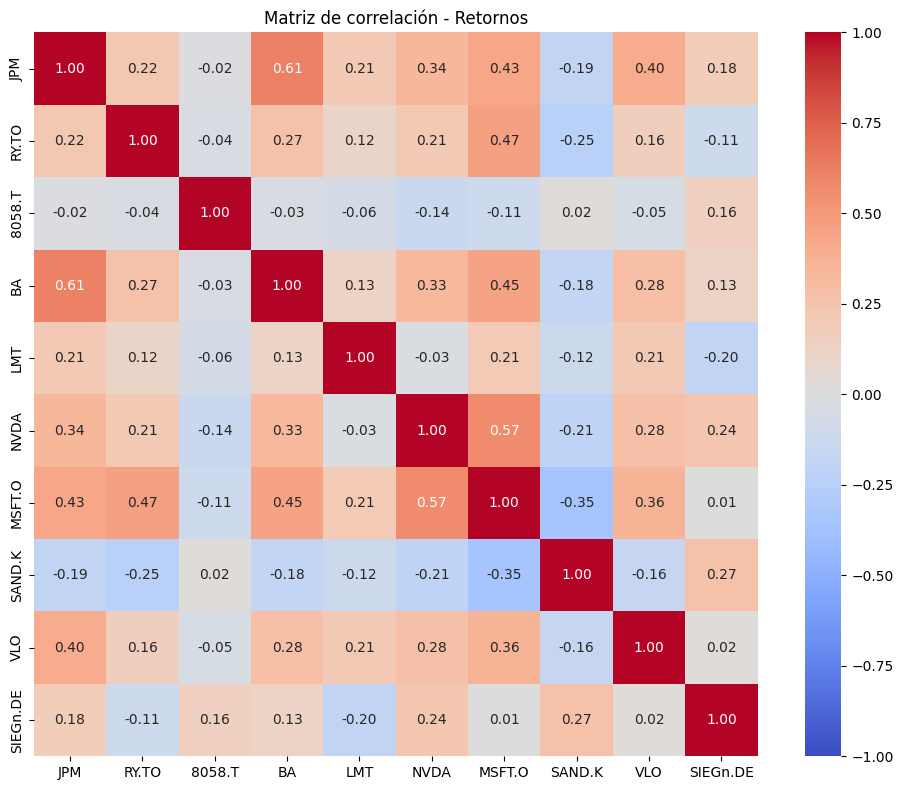

In [15]:
# Matriz de correlación (usando returns_mkv)
corr = returns_mkv.corr()
print('Correlación (primeras filas):')
display(corr.head())
plt.figure(figsize=(10,8))
import seaborn as sns
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, square=True)
plt.title('Matriz de correlación - Retornos')
plt.tight_layout()
plt.show()
# Guardar
corr.to_csv(OUT_DIR + '/correlation_matrix.csv')

## Mean-Variance: Simulación y Gráfico Mejorado

Generamos portfolios simulados, coloreamos por Sharpe, dibujamos la frontera eficiente y marcadores especiales (Max Sharpe, Min Vol, Kelly, Risk Parity, 1/n).

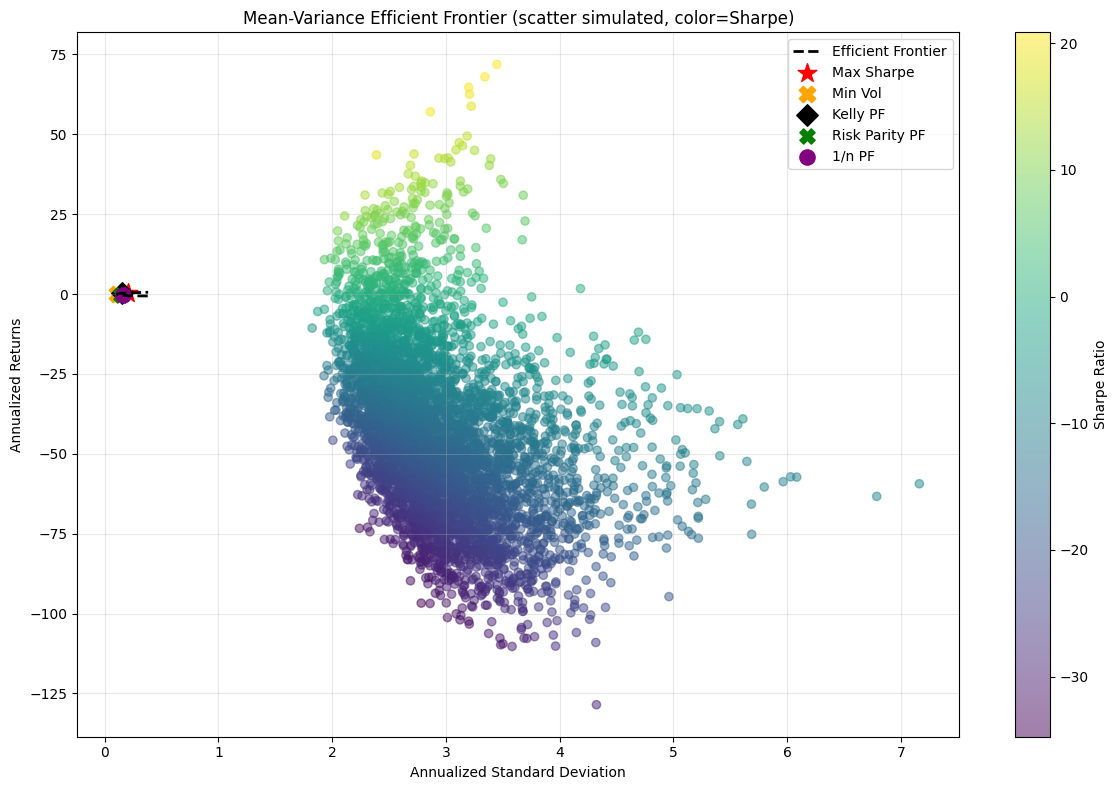

Max Sharpe -> Ret: 34.72% Vol: 20.13% Sharpe: 1.72
Min Vol    -> Ret: -3.43% Vol: 11.17% Sharpe: -0.31
Kelly PF   -> Ret: 19.45% Vol: 15.39% Sharpe: 1.26
RiskParity -> Ret: -17.36% Vol: 14.32% Sharpe: -1.21
1/n PF     -> Ret: -17.53% Vol: 16.05% Sharpe: -1.09


In [16]:
# Simular portfolios (rápido) y plot mejorado
def simulate_portfolios_quick(mean_ret, cov, n_sims=5000):
    n = len(mean_ret)
    w = np.random.dirichlet(np.ones(n), size=n_sims)
    ann_ret = (w @ mean_ret.values) * periods_per_year
    ann_vol = np.sqrt(np.einsum('ij,jk,ik->i', w, cov.values, w)) * np.sqrt(periods_per_year)
    sharpe = (ann_ret - rf) / ann_vol
    return pd.DataFrame({'Annualized Standard Deviation': ann_vol, 'Annualized Returns': ann_ret, 'Sharpe Ratio': sharpe}), w

simul_perf, simul_w = simulate_portfolios_quick(mean_annual, cov_annual, n_sims=5000)

# Usar fr_vol/fr_ret generados arriba como frontera (si existen)
fig, ax = plt.subplots(figsize=(12,8))
sc = ax.scatter(simul_perf['Annualized Standard Deviation'], simul_perf['Annualized Returns'],
                c=simul_perf['Sharpe Ratio'], cmap='viridis', alpha=0.5)
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Sharpe Ratio')
# dibujar frontera si fr_vol existe
try:
    ax.plot(fr_vol, fr_ret, '--k', lw=2, label='Efficient Frontier')
except Exception:
    pass
# marcar portafolios especiales
r_ms, sd_ms = ret_ms, vol_ms
ax.scatter(sd_ms, r_ms, marker='*', color='red', s=200, label='Max Sharpe')
r_mv, sd_mv = ret_mv, vol_mv
ax.scatter(sd_mv, r_mv, marker='X', color='orange', s=140, label='Min Vol')
# Kelly approximation
try:
    precision = np.linalg.inv(cov_annual)
    kelly_w = precision.dot(mean_annual)
    kelly_w = np.clip(kelly_w, 0, None)
    kelly_w = kelly_w / np.sum(np.abs(kelly_w))
    r_k, sd_k, _ = portfolio_perf(kelly_w)
    ax.scatter(sd_k, r_k, marker='D', color='black', s=120, label='Kelly PF')
except Exception:
    pass
# Risk parity (inverse vol)
std = returns_mkv.std()
    
rp_w = (1 / std).fillna(0)
rp_w = rp_w / rp_w.sum()
r_rp, sd_rp, _ = portfolio_perf(rp_w.values)
ax.scatter(sd_rp, r_rp, marker='X', color='green', s=120, label='Risk Parity PF')
# 1/n
r_1n, sd_1n, _ = portfolio_perf(np.full(n_assets, 1/n_assets))
ax.scatter(sd_1n, r_1n, marker='o', color='purple', s=120, label='1/n PF')

ax.set_xlabel('Annualized Standard Deviation')
ax.set_ylabel('Annualized Returns')
ax.set_title('Mean-Variance Efficient Frontier (scatter simulated, color=Sharpe)')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# imprimir resumen de performances
print('Max Sharpe -> Ret: {:.2%} Vol: {:.2%} Sharpe: {:.2f}'.format(r_ms, sd_ms, (r_ms-rf)/sd_ms))
print('Min Vol    -> Ret: {:.2%} Vol: {:.2%} Sharpe: {:.2f}'.format(r_mv, sd_mv, (r_mv-rf)/sd_mv))
try:
    print('Kelly PF   -> Ret: {:.2%} Vol: {:.2%} Sharpe: {:.2f}'.format(r_k, sd_k, (r_k-rf)/sd_k))
except Exception:
    pass
print('RiskParity -> Ret: {:.2%} Vol: {:.2%} Sharpe: {:.2f}'.format(r_rp, sd_rp, (r_rp-rf)/sd_rp))
print('1/n PF     -> Ret: {:.2%} Vol: {:.2%} Sharpe: {:.2f}'.format(r_1n, sd_1n, (r_1n-rf)/sd_1n))

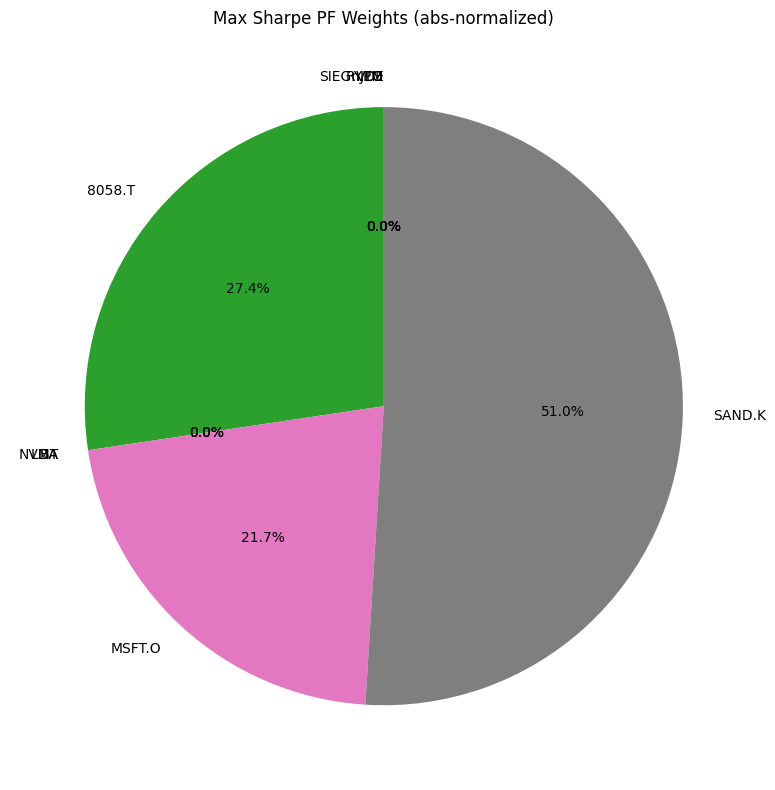

Pesos Max Sharpe:


SAND.K     0.5099
8058.T     0.2735
MSFT.O     0.2166
LMT        0.0000
RY.TO      0.0000
NVDA       0.0000
JPM        0.0000
BA         0.0000
VLO        0.0000
SIEGn.DE   0.0000
dtype: float64

In [17]:
# Pie chart con pesos del Max Sharpe PF (normalizados en valor absoluto para visualizar participación)
try:
    w_ms = np.abs(res_ms.x)
    w_ms = w_ms / np.sum(w_ms)
    wt = pd.Series(w_ms, index=returns_mkv.columns)
    fig, ax = plt.subplots(figsize=(8,8))
    ax.pie(wt, labels=wt.index, autopct='%1.1f%%', startangle=90)
    ax.set_title('Max Sharpe PF Weights (abs-normalized)')
    plt.tight_layout()
    plt.show()
    print('Pesos Max Sharpe:')
    display(wt.sort_values(ascending=False))
    wt.to_csv(OUT_DIR + '/max_sharpe_weights.csv')
except Exception as e:
    print('Error generando pie chart:', e)

### Interpretación Práctica

1. Pesos de Markowitz: Los pesos Max Sharpe maximizan (Retorno - rf) / Vol. Úsalos como proporciones de capital. Rebalancea periódicamente (ej. mensual o trimestral) para aproximarte al perfil calculado.
2. Señales Técnicas: Dentro de cada activo puedes aplicar la señal (posición +1 / -1) para modular la exposición. Ejemplo: Peso teórico * Señal = Exposición efectiva.
3. Riesgo: Verifica concentración (suma de pesos grandes). Puedes imponer límites agregando restricciones en la optimización.
4. No es predicción: Los pesos reflejan media y covarianza históricas. Si el régimen de mercado cambia, los parámetros deben recalibrarse.
5. Próximos pasos: Añadir costos, límites (mín-max por activo), control de turnover, y usar retornos esperados ajustados (factor models o blended forecasts).

Con esto tienes: (a) Generación de señales reactivas por activo y (b) Asignación óptima de capital cruzado. Listo para experimentar.